In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from financepy.utils import *
from financepy.products.equity import *
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay
from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore")

####################################################################
#  FINANCEPY BETA Version 0.370 - This build: 28 Oct 2024 at 20:26 #
#     This software is distributed FREE AND WITHOUT ANY WARRANTY   #
#  Report bugs as issues at https://github.com/domokane/FinancePy  #
####################################################################



## Variance Swaps

* (a) In this question you simulate a lognormal stock price process and simulate the dynamic
hedging of a 1 year Variance swap
* (b) Assume daily hedging for a process with S(0) = 100, a volatility σ = 0.30 and a
growth rate of µ = 0.05. Assume 252 business days a year.
* (c) Calculate the net proceeds of the dynamic hedging strategy of investing 2/T dollars
per day in the stock.
* (d) Take into account the cost and payoff of the log contract.
* (e) Simulate 10,000 paths of the stock price and use them to compute a histogram of the
final P&L of a variance swap that has been hedged dynamically

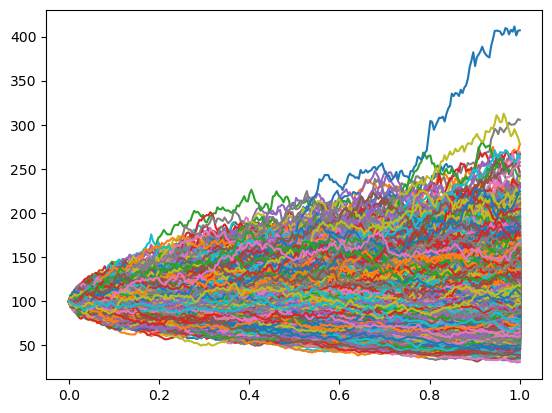

In [2]:
# Inputs
S0 = 100        
sigma = 0.30    
mu = 0.05       
T = 1           
n_days = 252    
dt = T / n_days 
n_simulations = 10000 # Number of simulations

# 1. Simulate the stock price process
def simulate_gbm(S0, mu, sigma, T, n_days, n_simulations):
    dt = T / n_days
    dW = np.random.normal(0, np.sqrt(dt), size=(n_simulations, n_days))
    S = np.zeros((n_simulations, n_days + 1))
    S[:, 0] = S0
    for t in range(1, n_days + 1):
        S[:, t] = S[:, t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * dW[:, t-1])
    return S

# Simulate stock price paths
stock_paths = simulate_gbm(S0, mu, sigma, T, n_days, n_simulations)
x = np.linspace(0, T, n_days + 1)
for i in range(n_simulations):
    plt.plot(x, stock_paths[i, :])

Implement dynamic hedging strategy

In [3]:
def dynamic_hedging(stock_paths, T, n_days):
    dt = T / n_days
    hedging_pnl = np.zeros(stock_paths.shape[0])
    for i in range(stock_paths.shape[0]):
        S = stock_paths[i, :]
        hedge = 2 / T * (1 / S[:-1]) # Hedging position at each time step
        dS = S[1:] - S[:-1]         # Stock price changes
        hedging_pnl[i] = np.sum(hedge * dS) * dt
    return hedging_pnl

# Calculate P&L from dynamic hedging
hedging_pnl = dynamic_hedging(stock_paths, T, n_days)
print(hedging_pnl)

[ 0.00023079  0.0013529  -0.00250743 ... -0.00079319  0.00180177
 -0.00220722]


Include log contract payoff

In [4]:
def log_contract_payoff(stock_paths):
    S_T = stock_paths[:, -1] 
    payoff = -2 / T * np.log(S_T / S0)
    return payoff

log_payoff = log_contract_payoff(stock_paths)

Histogram of the Final Pnl

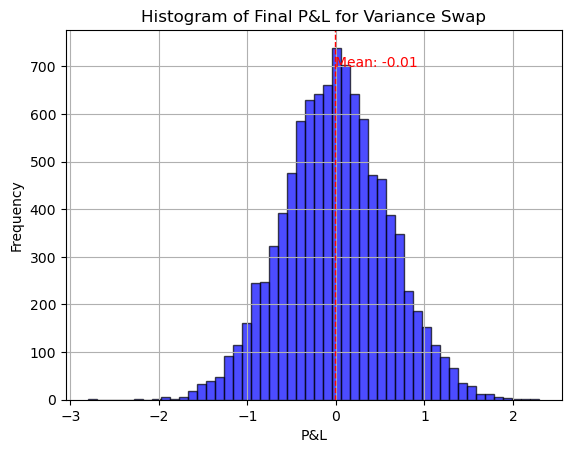

In [5]:
total_pnl = hedging_pnl + log_payoff

# Plot histogram of P&L
plt.hist(total_pnl, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.title('Histogram of Final P&L for Variance Swap')
plt.xlabel('P&L')
plt.ylabel('Frequency')
plt.grid(True)
mean_pnl = np.mean(total_pnl)
plt.axvline(mean_pnl, color='red', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(mean_pnl*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(mean_pnl), color='red')
plt.show()